In [44]:
import pandas as pd
import numpy as np
import yaml
import importlib

# Statistical analysis
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [8]:
import_str = "/ceph/projects/179_Oncdon/shawn.loo/workspace/"

### Metadata Imports

In [9]:
metadata_V107_w_inh = pd.read_excel(f"{import_str}data/rawdata/CC_longitudinal_data_standardized_v220250603_reformatted.xlsx", sheet_name = "CC_longitudinal_metadata_w_inh")
metadata_E975_w_inh = pd.read_excel(f"{import_str}data/rawdata/E100051975_BR_longitudinal_metadata_dev1_v220250603.xlsx", sheet_name = "BR_longitudinal_metadata_w_inh")

### Raw Data Imports

In [11]:
V107_data = pd.read_csv(f"{import_str}V107_long_df")
E975_data = pd.read_csv(f"{import_str}E975_long_df")

In [12]:
V107_data

,genus,phylum,sample_id,abundance,group,week
0,Acidaminococcus,Firmicutes,179supB00007a,0.00000,R,week0
1,Acidipropionibacterium,Actinobacteria,179supB00007a,0.00000,R,week0
2,Actinobaculum,Actinobacteria,179supB00007a,0.00000,R,week0
3,Actinomyces,Actinobacteria,179supB00007a,0.72184,R,week0
4,Adlercreutzia,Actinobacteria,179supB00007a,0.00000,R,week0
...,...,...,...,...,...,...
105259,Yanshouia,Firmicutes,179fece00063a,0.00000,NR,week6
105260,Yeguia,Firmicutes,179fece00063a,0.00000,NR,week6
105261,Youxingia,Firmicutes,179fece00063a,0.00000,NR,week6
105262,Zhenhengia,Firmicutes,179fece00063a,0.00000,NR,week6


### Extracting Target Columns in Metadata

In [15]:
target_col = ["sample_id",
              "pt_identifier",
              "ave_inh_A375 (% viable cells, 100% = no inhibition)",
              "ave_inh_CHL1 (% viable cells, 100% = no inhibition)",
              "ave_inh_SKMEL28 (% viable cells, 100% = no inhibition)",
              "ave_inh_ESTDAB105 (% viable cells, 100% = no inhibition)", 
              "ave_inh_B16F10 (% viable cells, 100% = no inhibition)"]

metadata_V107 = metadata_V107_w_inh[target_col]
metadata_E975 = metadata_E975_w_inh[target_col]

# Renaming columns
metadata_V107.columns = metadata_V107.columns.str.split(" ", n = 1).str[0]
metadata_E975.columns = metadata_E975.columns.str.split(" ", n = 1).str[0]

### Metadata Handling

In [16]:
metadata_V107 = metadata_V107.dropna(axis = 0, how = "any")
metadata_E975 = metadata_E975.dropna(axis = 0, how = "any")

In [17]:
# Merging them together
V107_main = V107_data.merge(metadata_V107, on="sample_id", how="inner")
E975_main = E975_data.merge(metadata_E975, on="sample_id", how="inner")

In [18]:
V107_main

,genus,phylum,sample_id,abundance,group,week,pt_identifier,ave_inh_A375,ave_inh_CHL1,ave_inh_SKMEL28,ave_inh_ESTDAB105,ave_inh_B16F10
0,Acidaminococcus,Firmicutes,179supA00011a,0.00000,R,week1,1010945946,40.717629,63.579830,55.880075,71.577655,68.731642
1,Acidipropionibacterium,Actinobacteria,179supA00011a,0.94485,R,week1,1010945946,40.717629,63.579830,55.880075,71.577655,68.731642
2,Actinobaculum,Actinobacteria,179supA00011a,0.00000,R,week1,1010945946,40.717629,63.579830,55.880075,71.577655,68.731642
3,Actinomyces,Actinobacteria,179supA00011a,0.00000,R,week1,1010945946,40.717629,63.579830,55.880075,71.577655,68.731642
4,Adlercreutzia,Actinobacteria,179supA00011a,0.00000,R,week1,1010945946,40.717629,63.579830,55.880075,71.577655,68.731642
...,...,...,...,...,...,...,...,...,...,...,...,...
90123,Yanshouia,Firmicutes,179fece00063a,0.00000,NR,week6,MAID-1101.1,137.549997,78.202435,91.674312,76.856240,67.514778
90124,Yeguia,Firmicutes,179fece00063a,0.00000,NR,week6,MAID-1101.1,137.549997,78.202435,91.674312,76.856240,67.514778
90125,Youxingia,Firmicutes,179fece00063a,0.00000,NR,week6,MAID-1101.1,137.549997,78.202435,91.674312,76.856240,67.514778
90126,Zhenhengia,Firmicutes,179fece00063a,0.00000,NR,week6,MAID-1101.1,137.549997,78.202435,91.674312,76.856240,67.514778


### Running statistical test

In [19]:
cancer_columns = ["ave_inh_A375",
                  "ave_inh_CHL1",
                  "ave_inh_SKMEL28",
                  "ave_inh_ESTDAB105", 
                  "ave_inh_B16F10"]


# Perform Spearman coorelation
def run_spearman(df, target_cols):
    
    test_result = []

    for cancer in target_cols:
        for genus, dataset in df.groupby("genus"):

            # Spearman test
            rho_value, p_value = spearmanr(dataset["abundance"], dataset[cancer], nan_policy="omit")

            test_result.append({"genus": genus,
                                "cancer_line": cancer,
                                "rho_value": rho_value,
                                "p_value": p_value})
            
    output = pd.DataFrame(test_result)
    
    # Calculating FDR value
    nonNA_output = output["p_value"].notna()
    
    fdrs_result = multipletests(output.loc[nonNA_output, "p_value"], method = "fdr_bh")[1]
    
    output.loc[nonNA_output, "fdr"] = fdrs_result
    
    # Remove NA
    output = output.dropna(subset=["rho_value", "p_value", "fdr"])

    return output

In [20]:
V107_stats = run_spearman(V107_main, cancer_columns)
E975_stats = run_spearman(E975_main, cancer_columns)

/tmp/ipykernel_2964418/2869067214.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_value, p_value = spearmanr(dataset["abundance"], dataset[cancer], nan_policy="omit")
/tmp/ipykernel_2964418/2869067214.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_value, p_value = spearmanr(dataset["abundance"], dataset[cancer], nan_policy="omit")
/tmp/ipykernel_2964418/2869067214.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_value, p_value = spearmanr(dataset["abundance"], dataset[cancer], nan_policy="omit")
/tmp/ipykernel_2964418/2869067214.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_value, p_value = spearmanr(dataset["abundance"], dataset[cancer], nan_policy="omit")
/tmp/ipykernel_2964418/2869067214.py:17: ConstantInputWarning: An input array is constant; the c

In [21]:
# Filtering significant result
V107_stats_sig = V107_stats[(V107_stats["fdr"] < 0.05)]
E975_stats_sig = E975_stats[(E975_stats["fdr"] < 0.05)]

### Running Mixed Models

In [22]:
# For V107
output = []

# Standardizing columns
V107_main["pt_identifier"] = V107_main["pt_identifier"].astype(str)

# Going through each genus with its respective cancer_line
for _, rows in V107_stats_sig.iterrows():
    genus = rows["genus"]
    cancer_line = rows["cancer_line"]

    # Creating subset for genus in all weeks
    genus_subset_df = V107_main[V107_main["genus"] == genus].copy()

    # Data handling, converting week into numbers
    genus_subset_df["week_number"] = genus_subset_df["week"].str.replace("week", "").astype(int)

    # Running mixed models
    mixed_model = smf.mixedlm(f"{cancer_line} ~ abundance + week_number", data = genus_subset_df, groups = genus_subset_df["pt_identifier"]).fit()

    # Appending results
    output.append({
        "genus": genus,
        "cancer_line": cancer_line,
        "abundance_coef": mixed_model.params["abundance"],
        "abundance_p_value": mixed_model.pvalues["abundance"],
        "week_coef": mixed_model.params["week_number"],
        "week_p_value": mixed_model.pvalues["week_number"]})

V107_mm = pd.DataFrame(output)


/apps/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/apps/conda/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/apps/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/apps/conda/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/apps/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fai

In [23]:
V107_mm

,genus,cancer_line,abundance_coef,abundance_p_value,week_coef,week_p_value
0,Alistipes,ave_inh_A375,-0.634512,0.739489,6.884097,0.000128
1,Anaerobutyricum,ave_inh_A375,-2.363030,0.702132,6.864756,0.000130
2,Anaerostipes,ave_inh_A375,-2.273699,0.051775,5.789600,0.001430
3,Anaerotruncus,ave_inh_A375,-165.465541,0.279010,7.167316,0.000039
4,Barnesiella,ave_inh_A375,-0.839738,0.954817,7.006305,0.000098
...,...,...,...,...,...,...
125,Oscillospiraceae_unclassified,ave_inh_B16F10,-0.293401,0.565493,2.127423,0.066296
126,Parabacteroides,ave_inh_B16F10,-0.451019,0.363516,1.937847,0.098783
127,Phascolarctobacterium,ave_inh_B16F10,-1.692591,0.070690,2.064713,0.063985
128,Roseburia,ave_inh_B16F10,-47.589145,0.004273,1.341255,0.244379


In [24]:
# For E975

output = []

# Standardizing columns
E975_main["pt_identifier"] = E975_main["pt_identifier"].astype(str)

# Going through each genus with its respective cancer_line
for _, rows in E975_stats_sig.iterrows():
    genus = rows["genus"]
    cancer_line = rows["cancer_line"]

    # Creating subset for genus in all weeks
    genus_subset_df = E975_main[E975_main["genus"] == genus].copy()

    # Data handling, converting week into numbers
    genus_subset_df["week_number"] = genus_subset_df["week"].str.replace("day", "").astype(int)

    # Running mixed models
    mixed_model = smf.mixedlm(f"{cancer_line} ~ abundance + week_number", data = genus_subset_df, groups = genus_subset_df["pt_identifier"]).fit()

    # Appending results
    output.append({
        "genus": genus,
        "cancer_line": cancer_line,
        "abundance_coef": mixed_model.params["abundance"],
        "abundance_p_value": mixed_model.pvalues["abundance"],
        "week_coef": mixed_model.params["week_number"],
        "week_p_value": mixed_model.pvalues["week_number"]})

E975_mm = pd.DataFrame(output)

In [25]:
# Filter to significant
V107_mm_sig = V107_mm[V107_mm["abundance_p_value"] < 0.05]
E975_mm_sig = E975_mm[E975_mm["abundance_p_value"] < 0.05]

In [31]:
# Group data by cancer line
V107_grouped_sig = V107_mm_sig.groupby("cancer_line")["genus"].apply(list).to_dict()
E975_grouped_sig = E975_mm_sig.groupby("cancer_line")["genus"].apply(list).to_dict()

In [33]:
V107_grouped_sig

{'ave_inh_A375': ['Enterococcus',
  'Escherichia',
  'Eubacterium',
  'Lacticaseibacillus',
  'Phascolarctobacterium'],
 'ave_inh_B16F10': ['Adlercreutzia',
  'Akkermansia',
  'Anaerostipes',
  'Clostridiaceae_unclassified',
  'Escherichia',
  'Eubacteriaceae_unclassified',
  'Eubacteriales_unclassified',
  'Eubacterium',
  'GGB4569',
  'GGB4605',
  'GGB9758',
  'GGB9759',
  'Lacticaseibacillus',
  'Roseburia'],
 'ave_inh_CHL1': ['Actinomyces',
  'Adlercreutzia',
  'Anaerostipes',
  'Brotolimicola',
  'Eubacteriales_unclassified',
  'Eubacterium',
  'Fusicatenibacter',
  'GGB3277',
  'GGB9758',
  'GGB9760',
  'Intestinibacter',
  'Ruminococcus'],
 'ave_inh_ESTDAB105': ['Enterococcus',
  'Escherichia',
  'GGB4569',
  'GGB4605',
  'GGB9365',
  'Lacticaseibacillus',
  'Liquorilactobacillus'],
 'ave_inh_SKMEL28': ['Actinomyces',
  'Escherichia',
  'GGB3277',
  'GGB9365',
  'Lacticaseibacillus']}

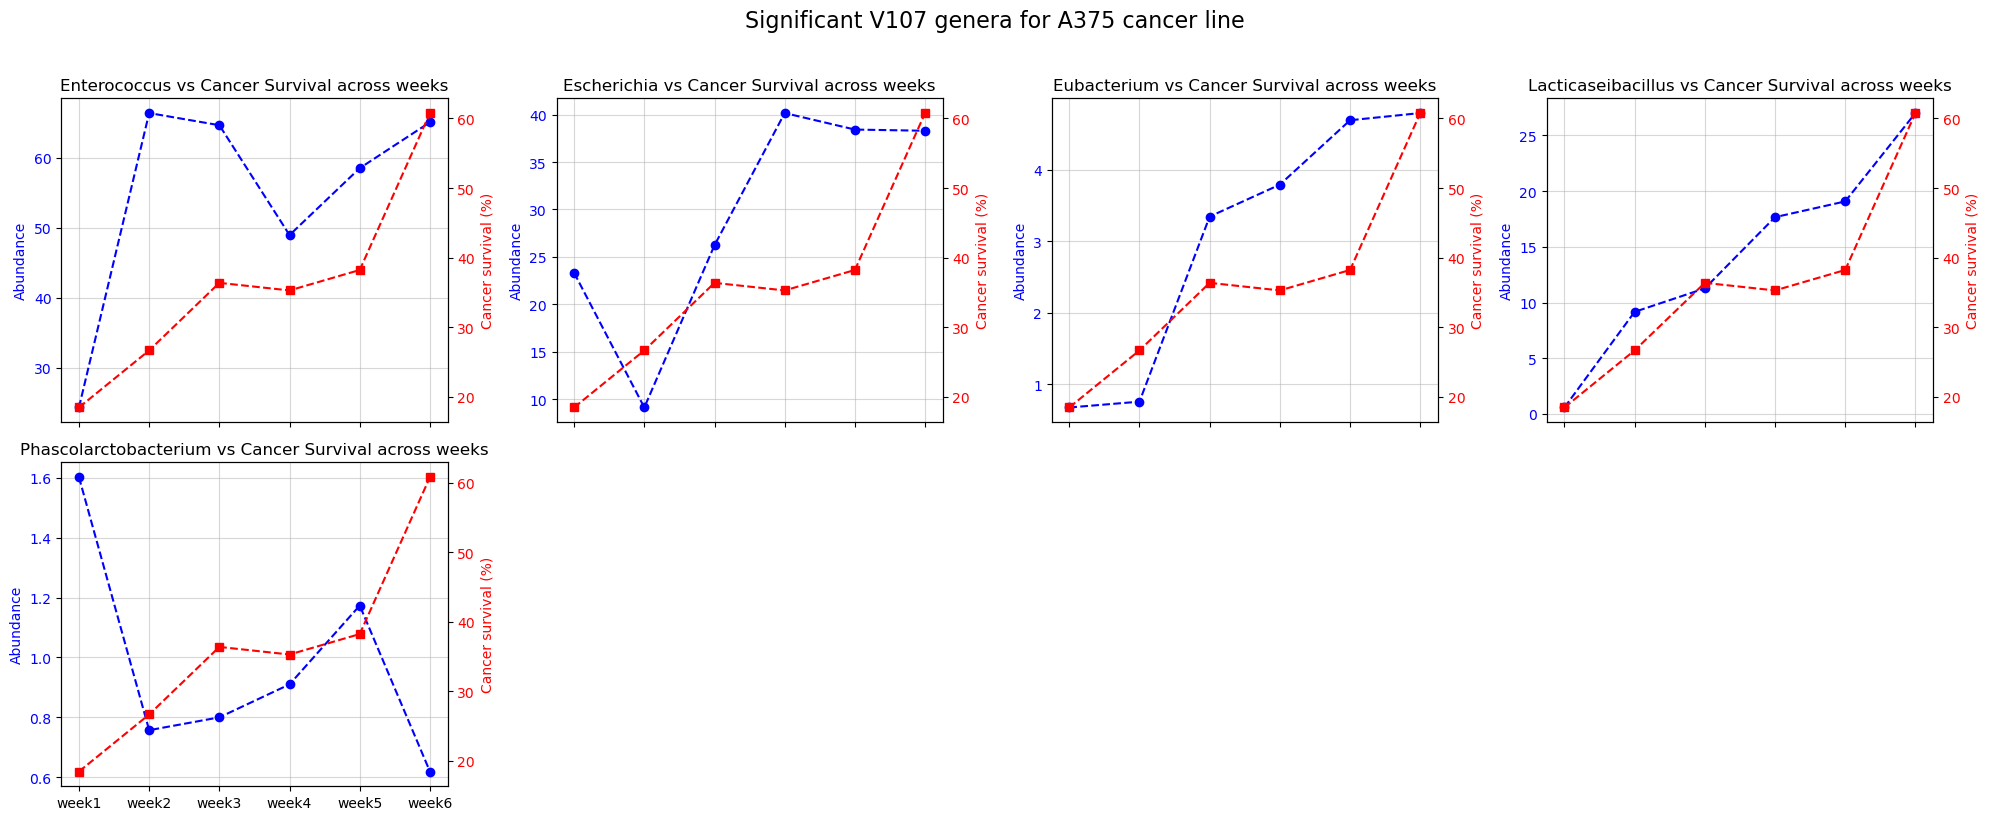

In [47]:
cancer_line = "ave_inh_A375"
genera = V107_grouped_sig[cancer_line]

ncols = min(4, len(genera))
nrows = math.ceil(len(genera) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex = True)
axes = axes.flatten()  # flatten 2D array to 1D for easy indexing

for i, genus in enumerate(genera):
    
    # Extracting subset from main dataset and computing mean for all samples
    genus_subset = V107_main[V107_main["genus"] == genus]
    extracted_df = genus_subset.groupby("week")[[cancer_line, "abundance"]].mean().reset_index()
    
    ax1 = axes[i]

    # Abundance plot
    ax1.plot(extracted_df["week"], extracted_df["abundance"], marker = "o", color = "blue", linestyle = "--")
    ax1.set_ylabel("Abundance", color = "blue")
    ax1.tick_params(axis = "y", labelcolor = "blue")
    ax1.grid(True, axis = "both", which = "major", linestyle = "-", alpha=0.5)

    # Cancer line plot
    ax2 = ax1.twinx()
    ax2.plot(extracted_df["week"], extracted_df[cancer_line], marker = "s", color = "red", linestyle = "--")
    ax2.set_ylabel("Cancer survival (%)", color = "red")
    ax2.tick_params(axis = "y", labelcolor = "red")

    ax1.set_title(f"{genus} vs Cancer Survival across weeks")
    
# Removing extra plots
for j in range(len(genera), len(axes)):
    fig.delaxes(axes[j])

plt.xlabel("Week")
plt.suptitle(f"Significant V107 genera for A375 cancer line", y = 1.02, fontsize = 16)
plt.tight_layout()
plt.savefig(f"significant_V107_genera_{cancer_line}.png", dpi = 600, bbox_inches = "tight")
plt.show()

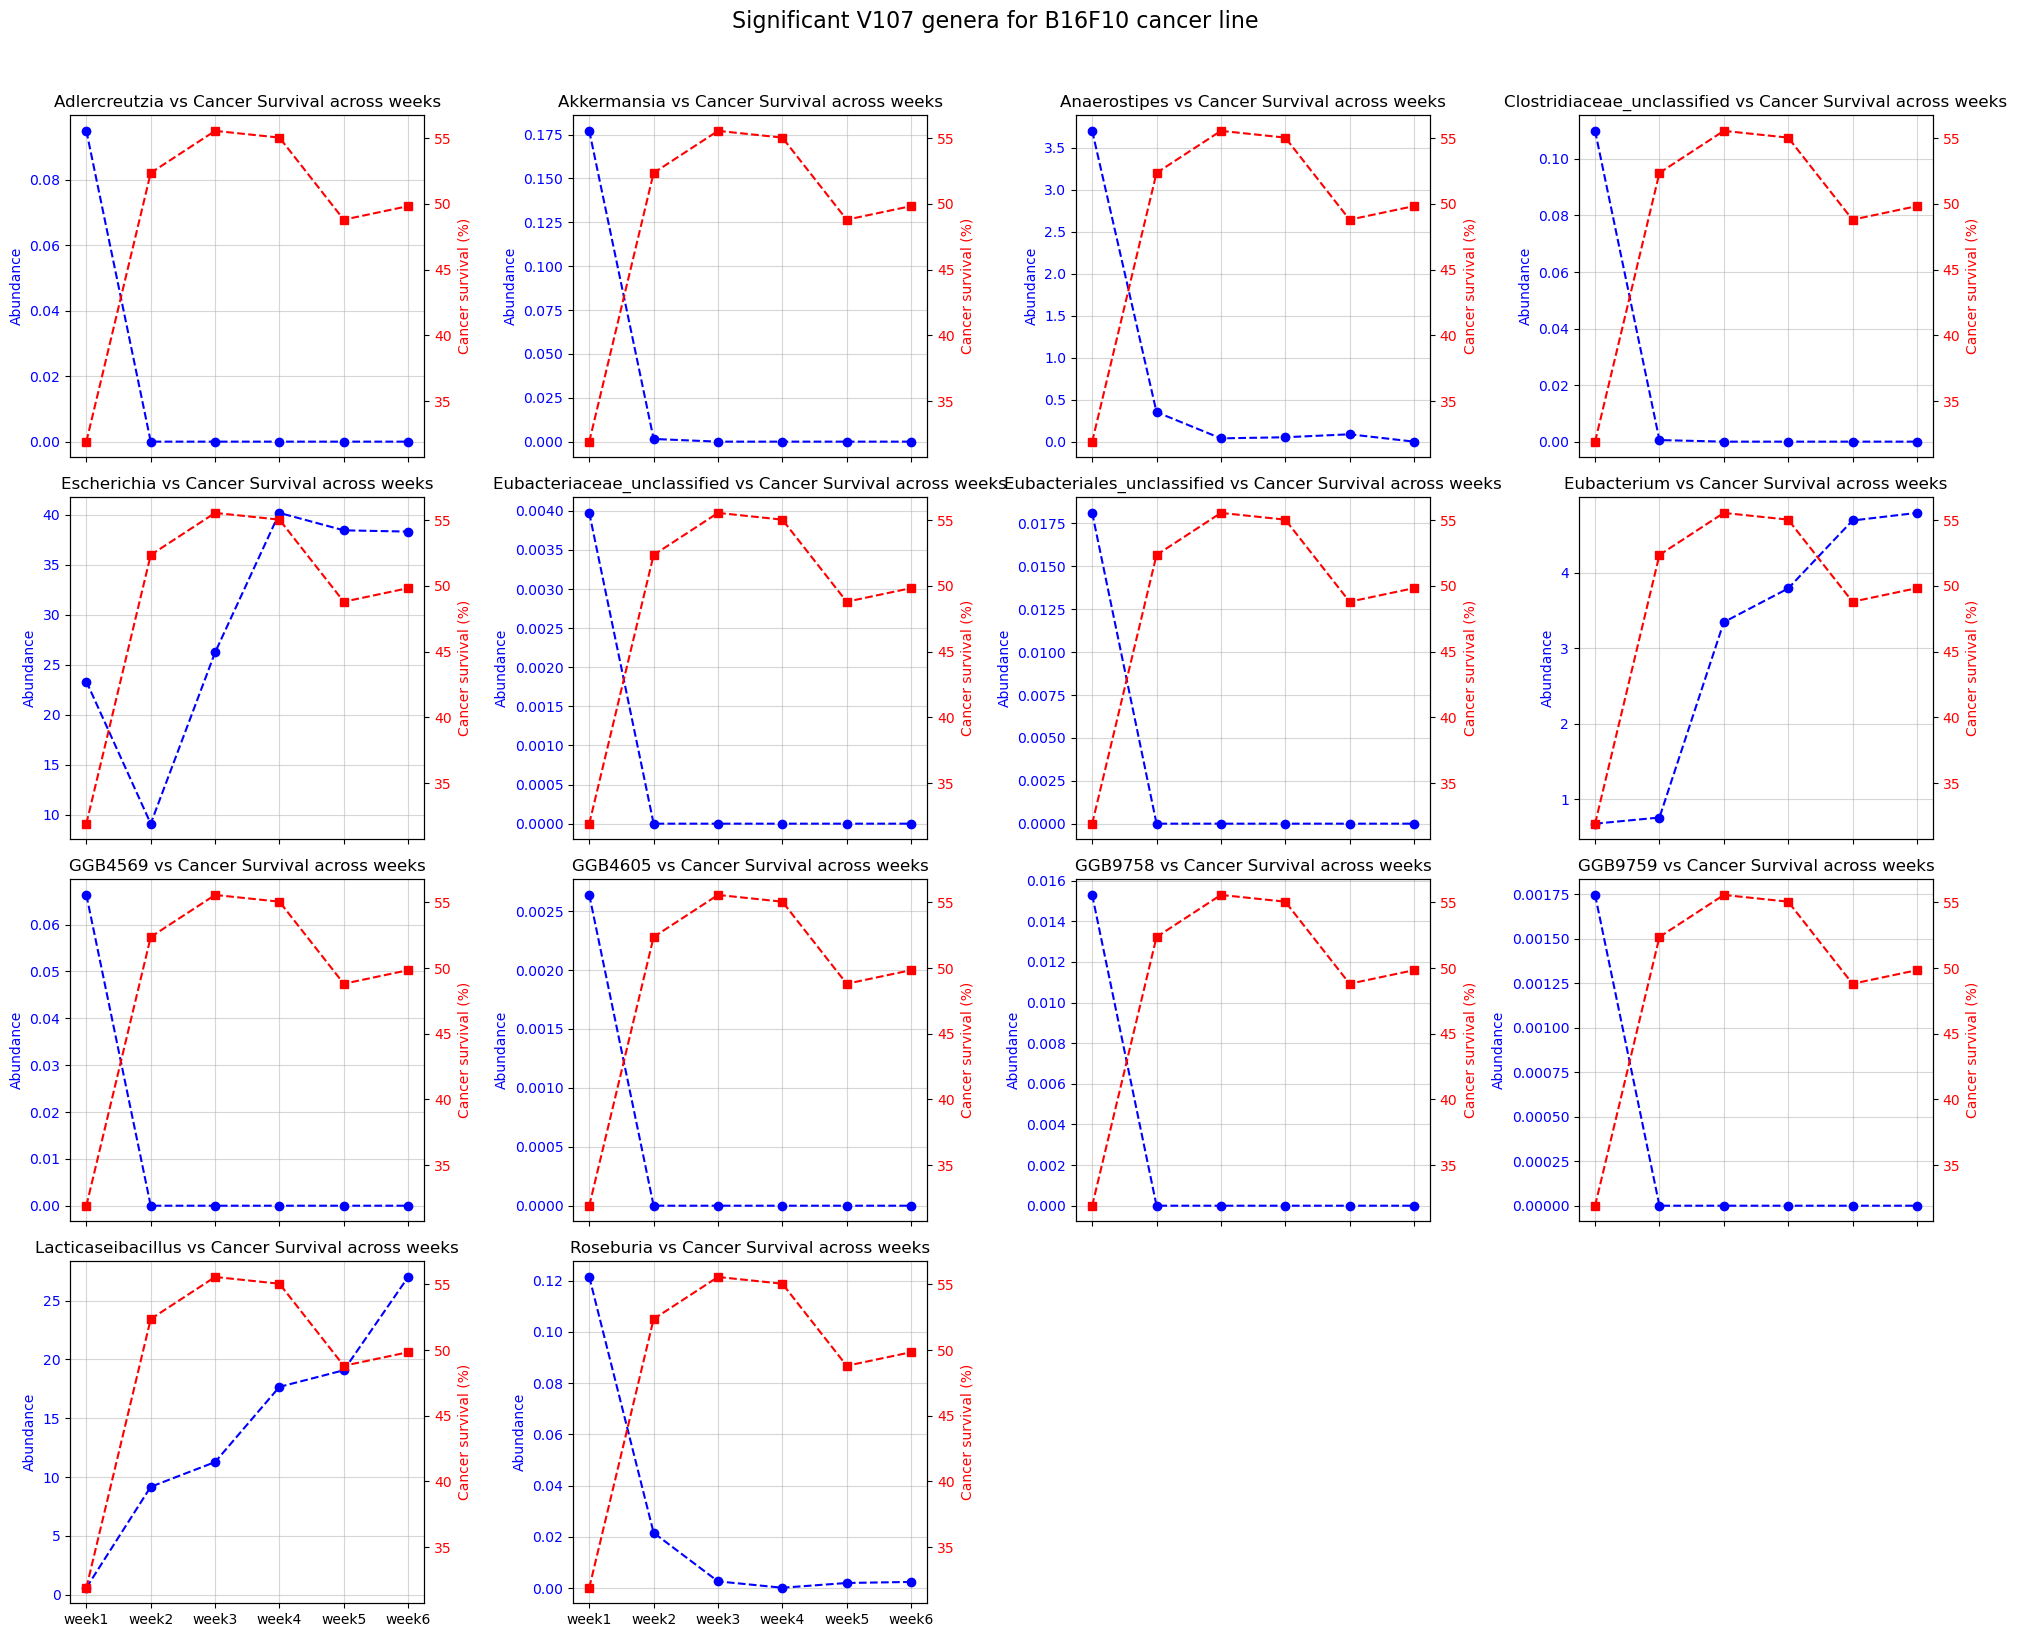

In [48]:
cancer_line = "ave_inh_B16F10"
genera = V107_grouped_sig[cancer_line]

ncols = min(4, len(genera))
nrows = math.ceil(len(genera) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex = True)
axes = axes.flatten()

for i, genus in enumerate(genera):
    
    # Extracting subset from main dataset and computing mean for all samples
    genus_subset = V107_main[V107_main["genus"] == genus]
    extracted_df = genus_subset.groupby("week")[[cancer_line, "abundance"]].mean().reset_index()
    
    ax1 = axes[i]

    # Abundance plot
    ax1.plot(extracted_df["week"], extracted_df["abundance"], marker = "o", color = "blue", linestyle = "--")
    ax1.set_ylabel("Abundance", color = "blue")
    ax1.tick_params(axis = "y", labelcolor = "blue")
    ax1.grid(True, axis = "both", which = "major", linestyle = "-", alpha=0.5)

    # Cancer line plot
    ax2 = ax1.twinx()
    ax2.plot(extracted_df["week"], extracted_df[cancer_line], marker = "s", color = "red", linestyle = "--")
    ax2.set_ylabel("Cancer survival (%)", color = "red")
    ax2.tick_params(axis = "y", labelcolor = "red")

    ax1.set_title(f"{genus} vs Cancer Survival across weeks")
    
# Removing extra plots
for j in range(len(genera), len(axes)):
    fig.delaxes(axes[j])

plt.xlabel("Week")
plt.suptitle(f"Significant V107 genera for B16F10 cancer line", y = 1.02, fontsize = 16)
plt.tight_layout()
plt.savefig(f"significant_V107_genera_{cancer_line}.png", dpi = 600, bbox_inches = "tight")
plt.show()


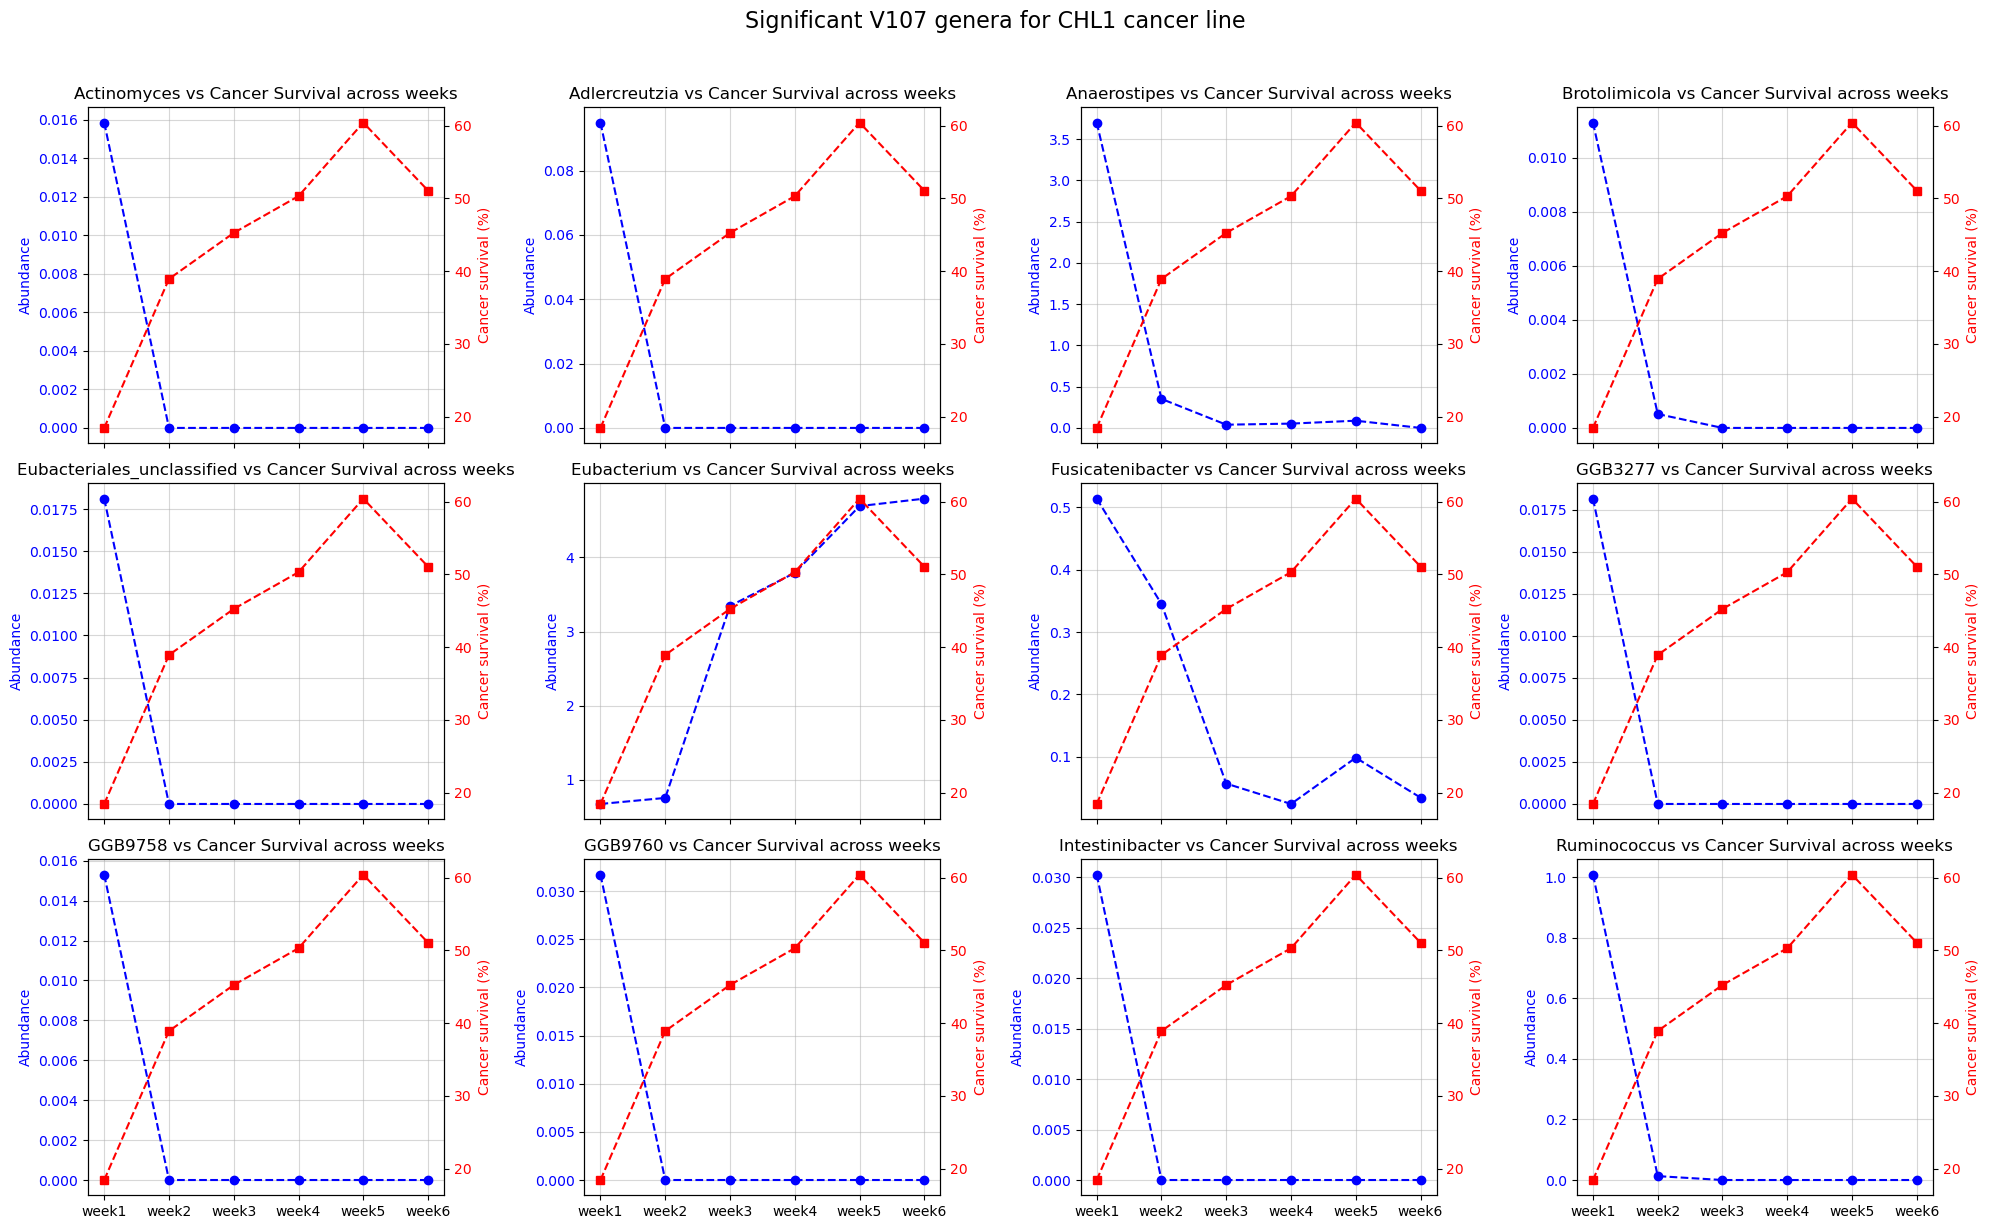

In [49]:
cancer_line = "ave_inh_CHL1"
genera = V107_grouped_sig[cancer_line]

ncols = min(4, len(genera))
nrows = math.ceil(len(genera) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex = True)
axes = axes.flatten()

for i, genus in enumerate(genera):
    
    # Extracting subset from main dataset and computing mean for all samples
    genus_subset = V107_main[V107_main["genus"] == genus]
    extracted_df = genus_subset.groupby("week")[[cancer_line, "abundance"]].mean().reset_index()
    
    ax1 = axes[i]

    # Abundance plot
    ax1.plot(extracted_df["week"], extracted_df["abundance"], marker = "o", color = "blue", linestyle = "--")
    ax1.set_ylabel("Abundance", color = "blue")
    ax1.tick_params(axis = "y", labelcolor = "blue")
    ax1.grid(True, axis = "both", which = "major", linestyle = "-", alpha=0.5)

    # Cancer line plot
    ax2 = ax1.twinx()
    ax2.plot(extracted_df["week"], extracted_df[cancer_line], marker = "s", color = "red", linestyle = "--")
    ax2.set_ylabel("Cancer survival (%)", color = "red")
    ax2.tick_params(axis = "y", labelcolor = "red")

    ax1.set_title(f"{genus} vs Cancer Survival across weeks")
    
# Removing extra plots
for j in range(len(genera), len(axes)):
    fig.delaxes(axes[j])

plt.xlabel("Week")
plt.suptitle(f"Significant V107 genera for CHL1 cancer line", y = 1.02, fontsize = 16)
plt.tight_layout()
plt.savefig(f"significant_V107_genera_{cancer_line}.png", dpi = 600, bbox_inches = "tight")
plt.show()

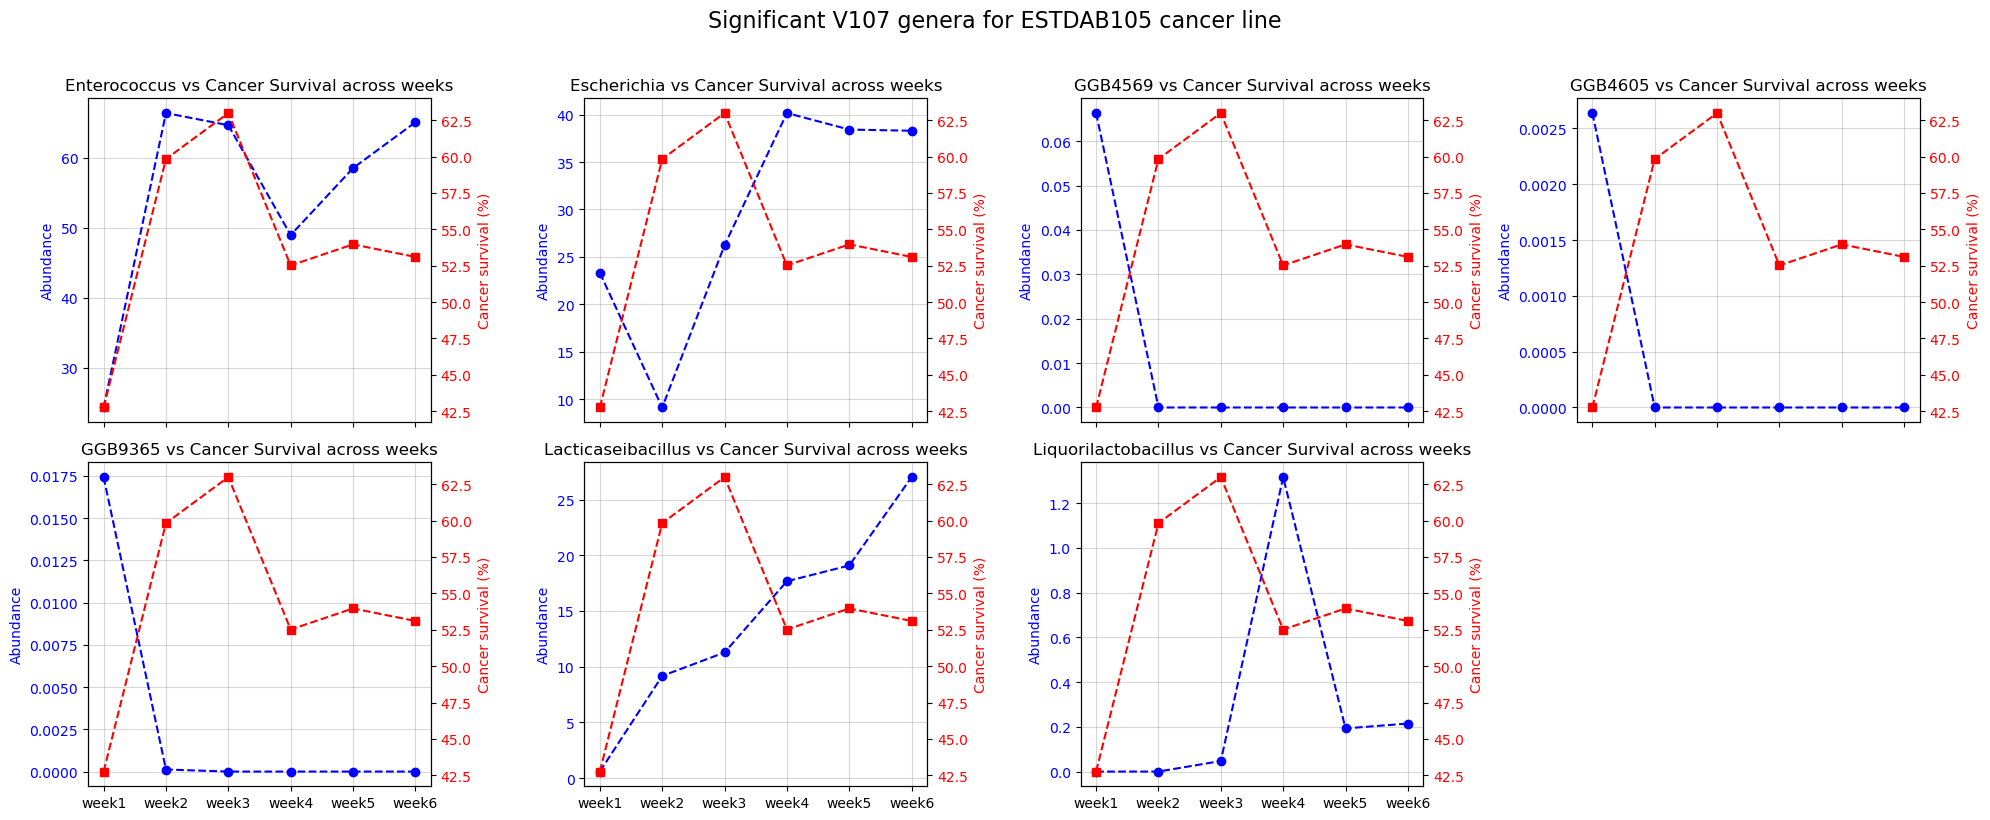

In [50]:
cancer_line = "ave_inh_ESTDAB105"
genera = V107_grouped_sig[cancer_line]

ncols = min(4, len(genera))
nrows = math.ceil(len(genera) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex = True)
axes = axes.flatten()

for i, genus in enumerate(genera):
    
    # Extracting subset from main dataset and computing mean for all samples
    genus_subset = V107_main[V107_main["genus"] == genus]
    extracted_df = genus_subset.groupby("week")[[cancer_line, "abundance"]].mean().reset_index()
    
    ax1 = axes[i]

    # Abundance plot
    ax1.plot(extracted_df["week"], extracted_df["abundance"], marker = "o", color = "blue", linestyle = "--")
    ax1.set_ylabel("Abundance", color = "blue")
    ax1.tick_params(axis = "y", labelcolor = "blue")
    ax1.grid(True, axis = "both", which = "major", linestyle = "-", alpha=0.5)

    # Cancer line plot
    ax2 = ax1.twinx()
    ax2.plot(extracted_df["week"], extracted_df[cancer_line], marker = "s", color = "red", linestyle = "--")
    ax2.set_ylabel("Cancer survival (%)", color = "red")
    ax2.tick_params(axis = "y", labelcolor = "red")

    ax1.set_title(f"{genus} vs Cancer Survival across weeks")
    
# Removing extra plots
for j in range(len(genera), len(axes)):
    fig.delaxes(axes[j])

plt.xlabel("Week")
plt.suptitle(f"Significant V107 genera for ESTDAB105 cancer line", y = 1.02, fontsize = 16)
plt.tight_layout()
plt.savefig(f"significant_V107_genera_{cancer_line}.png", dpi = 600, bbox_inches = "tight")
plt.show()

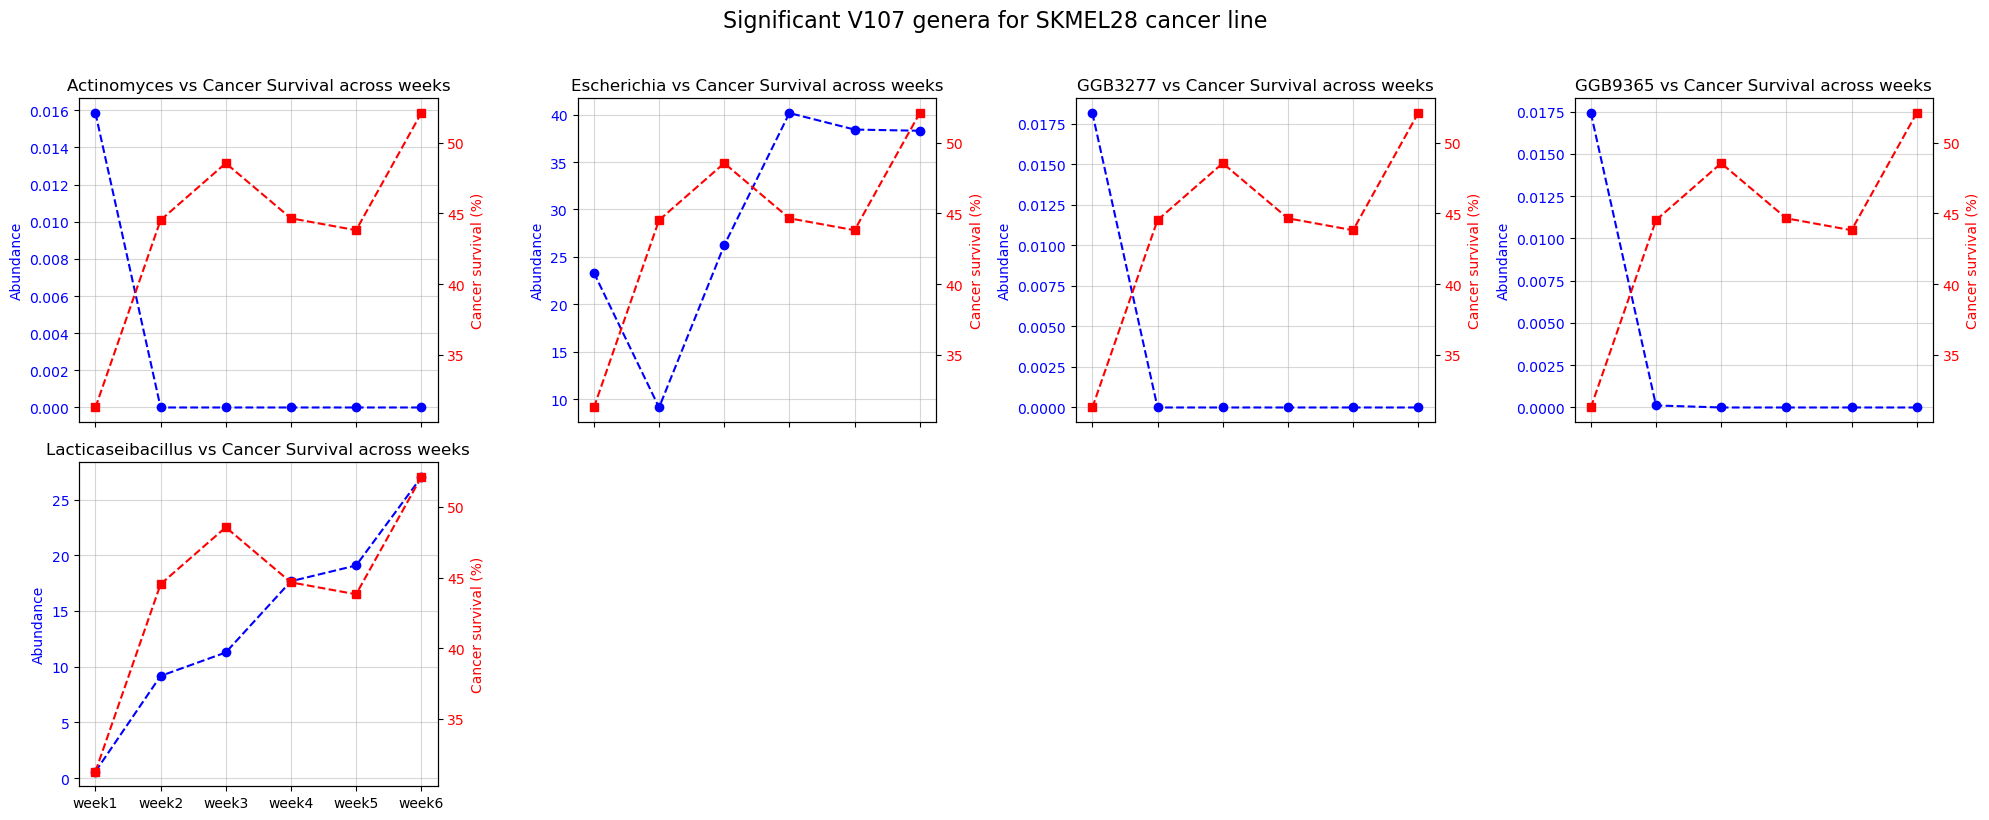

In [51]:
cancer_line = "ave_inh_SKMEL28"
genera = V107_grouped_sig[cancer_line]

ncols = min(4, len(genera))
nrows = math.ceil(len(genera) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex = True)
axes = axes.flatten()

for i, genus in enumerate(genera):
    
    # Extracting subset from main dataset and computing mean for all samples
    genus_subset = V107_main[V107_main["genus"] == genus]
    extracted_df = genus_subset.groupby("week")[[cancer_line, "abundance"]].mean().reset_index()
    
    ax1 = axes[i]

    # Abundance plot
    ax1.plot(extracted_df["week"], extracted_df["abundance"], marker = "o", color = "blue", linestyle = "--")
    ax1.set_ylabel("Abundance", color = "blue")
    ax1.tick_params(axis = "y", labelcolor = "blue")
    ax1.grid(True, axis = "both", which = "major", linestyle = "-", alpha=0.5)

    # Cancer line plot
    ax2 = ax1.twinx()
    ax2.plot(extracted_df["week"], extracted_df[cancer_line], marker = "s", color = "red", linestyle = "--")
    ax2.set_ylabel("Cancer survival (%)", color = "red")
    ax2.tick_params(axis = "y", labelcolor = "red")

    ax1.set_title(f"{genus} vs Cancer Survival across weeks")
    
# Removing extra plots
for j in range(len(genera), len(axes)):
    fig.delaxes(axes[j])

plt.xlabel("Week")
plt.suptitle(f"Significant V107 genera for SKMEL28 cancer line", y = 1.02, fontsize = 16)
plt.tight_layout()
plt.savefig(f"significant_V107_genera_{cancer_line}.png", dpi = 600, bbox_inches = "tight")
plt.show()

In [41]:
E975_grouped_sig

{'ave_inh_A375': ['Clostridium',
  'Coprococcus',
  'Enterocloster',
  'Mediterraneibacter'],
 'ave_inh_B16F10': ['Lachnoclostridium']}

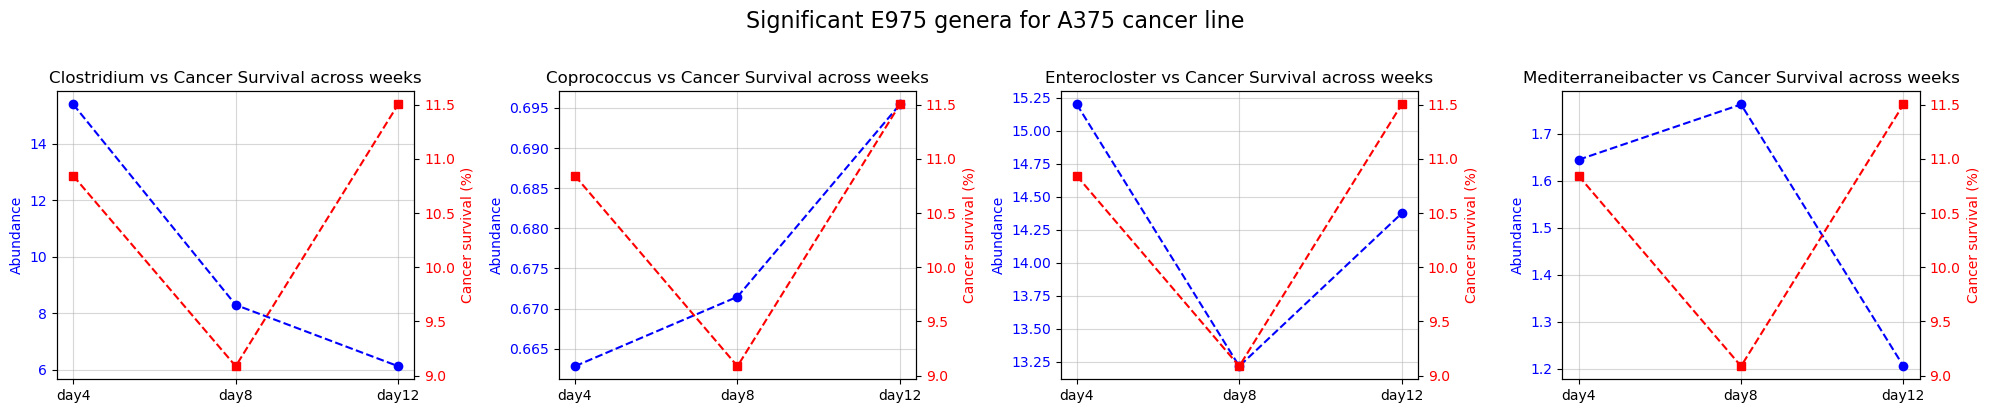

In [42]:
cancer_line = "ave_inh_A375"
genera = E975_grouped_sig[cancer_line]

ncols = len(genera)
nrows = 1

# Custom x-axis order
day_order = ["day4", "day8", "day12"]

# Plotting
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex = True)
axes = axes.flatten()

for i, genus in enumerate(genera):
    
    # Extracting subset from main dataset and computing mean for all samples
    genus_subset = E975_main[E975_main["genus"] == genus]
    extracted_df = genus_subset.groupby("week")[[cancer_line, "abundance"]].mean().reset_index()
    
    # Ordering x-axis
    extracted_df["week"] = pd.Categorical(extracted_df["week"], categories = day_order, ordered=True)
    extracted_df = extracted_df.sort_values("week")
    
    ax1 = axes[i]

    # Abundance plot
    ax1.plot(extracted_df["week"], extracted_df["abundance"], marker = "o", color = "blue", linestyle = "--")
    ax1.set_ylabel("Abundance", color = "blue")
    ax1.tick_params(axis = "y", labelcolor = "blue")
    ax1.grid(True, axis = "both", which = "major", linestyle = "-", alpha=0.5)

    # Cancer line plot
    ax2 = ax1.twinx()
    ax2.plot(extracted_df["week"], extracted_df[cancer_line], marker = "s", color = "red", linestyle = "--")
    ax2.set_ylabel("Cancer survival (%)", color = "red")
    ax2.tick_params(axis = "y", labelcolor = "red")

    ax1.set_title(f"{genus} vs Cancer Survival across weeks")

plt.xlabel("Week")
plt.suptitle(f"Significant E975 genera for A375 cancer line", y = 1.02, fontsize = 16)
plt.tight_layout()
plt.savefig(f"significant_E975_genera_{cancer_line}.png", dpi = 600, bbox_inches = "tight")
plt.show()

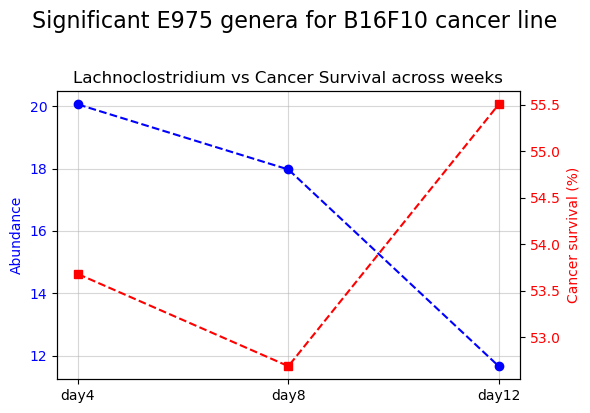

In [43]:
cancer_line = "ave_inh_B16F10"
genera = E975_grouped_sig[cancer_line][0]

# Extracting subset from main dataset and computing mean for all samples
genus_subset = E975_main[E975_main["genus"] == genera]
extracted_df = genus_subset.groupby("week")[[cancer_line, "abundance"]].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(6, 4))

# Setting up x-axis orders
day_order = ["day4", "day8", "day12"]
extracted_df["week"] = pd.Categorical(extracted_df["week"], categories = day_order, ordered=True)
extracted_df = extracted_df.sort_values("week")

# Abundance plot
ax1.plot(extracted_df["week"], extracted_df["abundance"], marker = "o", color = "blue", linestyle = "--")
ax1.set_ylabel("Abundance", color = "blue")
ax1.tick_params(axis = "y", labelcolor = "blue")
ax1.grid(True, axis = "both", which = "major", linestyle = "-", alpha=0.5)

# Cancer line plot
ax2 = ax1.twinx()
ax2.plot(extracted_df["week"], extracted_df[cancer_line], marker = "s", color = "red", linestyle = "--")
ax2.set_ylabel("Cancer survival (%)", color = "red")
ax2.tick_params(axis = "y", labelcolor = "red")

ax1.set_title(f"{genera} vs Cancer Survival across weeks")

plt.xlabel("Week")
plt.suptitle(f"Significant E975 genera for B16F10 cancer line", y = 1.02, fontsize = 16)
plt.tight_layout()
plt.savefig(f"significant_E975_genera_{cancer_line}.png", dpi = 600, bbox_inches = "tight")
plt.show()

In [154]:
E975_grouped_sig

{'ave_inh_A375': ['Clostridium',
  'Coprococcus',
  'Enterocloster',
  'Mediterraneibacter'],
 'ave_inh_B16F10': ['Lachnoclostridium']}